# Imports

In [1]:
import requests, json
import torch
import torchvision
from torchvision.io import read_video
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn#, FasterRCNN_ResNet50_FPN_Weights
import itertools
import matplotlib.patches as patches


# Load Data JSON

In [2]:
backend = requests.get("https://backend.kaimerra.com/feed")
feed = backend.json()

In [3]:
#Download latest video, save to file
url = feed[-1]['video_url']
r = requests.get(url, allow_redirects=True)
open('kaimerra_vid', 'wb').write(r.content)

2821857

In [4]:
#Load video as torch tensor
reader = torchvision.io.VideoReader('kaimerra_vid', "video")
output = []
#reader.seek(2)
for frame in itertools.takewhile(lambda x: x['pts'] <= 45, reader.seek(40)):
    output.append(frame['data'])

frames = torch.stack(output[0:5], dim=0)

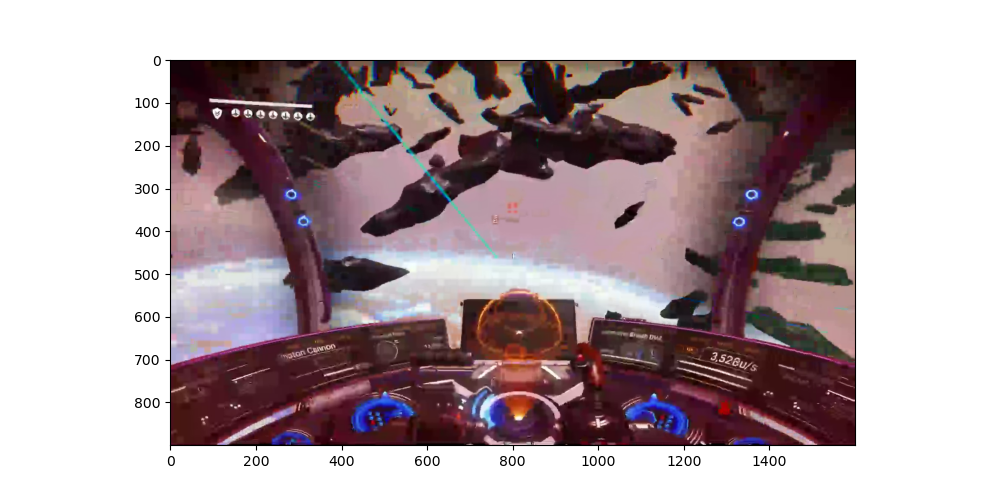

In [6]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

fig = plt.figure(figsize = (10,5))
ani_frames = [] # for storing the generated images
# fig, ax = plt.subplots(1,2)
for i in range(len(frames)):
    ani_frames.append([plt.imshow(frames[i].permute(1,2,0).numpy(), cmap=cm.Greys_r,animated=True)])
    

ani = animation.ArtistAnimation(fig, ani_frames, interval=30, blit=True,
                                repeat_delay=0)
# ani.save('movie.mp4')
plt.show()


In [7]:
model = fasterrcnn_resnet50_fpn(pretrained = True, progress=False)
model = model.eval()

CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

outputs = model(frames.float()/255)

/home/alec/anaconda3/envs/Kaimerra/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


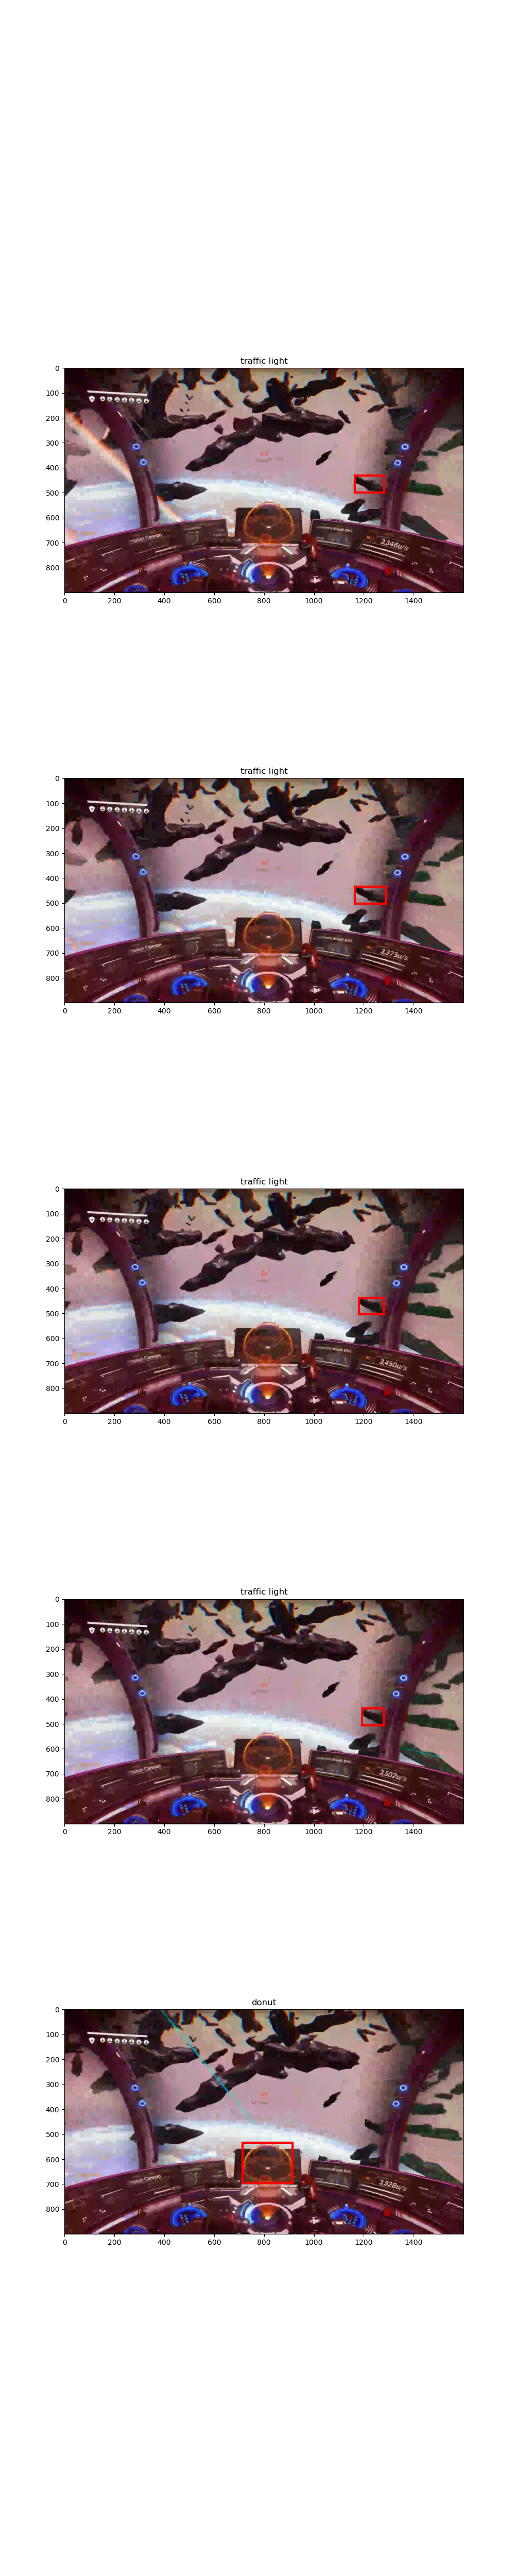

In [10]:
score_idx = 0 #The scores are listed in order, so the 0th score was the top scoring bounding box

label_idxs = [output['labels'][score_idx] for output in outputs]
labels = [CATEGORY_NAMES[idx] for idx in label_idxs]
boxes = [output['boxes'][score_idx] for output in outputs]

def get_box(box):
    xy = box[0:2]
    width = box[2] - box[0]
    height = box[3] - box[1]
    return xy.detach().numpy(), width.detach().numpy(), height.detach().numpy()
    
fig, ax = plt.subplots(len(outputs),figsize = (10,10 * len(outputs)))
for idx,frame in enumerate(frames):
    ax[idx].imshow(frame.permute(1,2,0))
    xy, width, height = get_box(boxes[idx])
    
    rectangle = patches.Rectangle(xy = xy,
                                  width = width,
                                  height = height,
                                  linewidth=3, edgecolor='r', facecolor='none')#, angle=0.0, **kwargs)
    ax[idx].add_patch(rectangle)
    ax[idx].set_title(labels[idx])